# Lab 2.5: Training Loop Implementation

**Duration:** 45 minutes

## Learning Objectives
By the end of this lab, you will be able to:
- Implement comprehensive training loops with advanced features
- Add early stopping, learning rate scheduling, and model checkpointing
- Implement different batch processing strategies
- Create monitoring and logging systems for training progress
- Handle overfitting through validation monitoring
- Build robust training pipelines for production use

## Prerequisites
- Python 3.8+
- NumPy, Matplotlib
- Completed Lab 2.4 (Neural Network Class Design)
- Understanding of gradient descent and backpropagation

## Overview
A well-implemented training loop is crucial for successfully training neural networks. This lab focuses on building sophisticated training loops that include modern techniques like early stopping, learning rate scheduling, and comprehensive monitoring. You'll learn to create training systems that are both robust and production-ready.

## Step 1: Environment Setup and Import Previous Components

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple, Optional, Callable, Any
from abc import ABC, abstractmethod
import time
import json
from collections import defaultdict, deque
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Configure matplotlib
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)

print("Environment setup complete!")
print(f"NumPy version: {np.__version__}")

print("\nTraining Loop Components:")
print("=" * 25)
print("1. Batch Processing: Handle different batch sizes and data loading")
print("2. Early Stopping: Prevent overfitting by monitoring validation metrics")
print("3. Learning Rate Scheduling: Adaptive learning rate adjustment")
print("4. Model Checkpointing: Save best models during training")
print("5. Progress Monitoring: Real-time tracking of training metrics")
print("6. Validation Evaluation: Regular validation set assessment")

Environment setup complete!
NumPy version: 2.3.2

Training Loop Components:
1. Batch Processing: Handle different batch sizes and data loading
2. Early Stopping: Prevent overfitting by monitoring validation metrics
3. Learning Rate Scheduling: Adaptive learning rate adjustment
4. Model Checkpointing: Save best models during training
5. Progress Monitoring: Real-time tracking of training metrics
6. Validation Evaluation: Regular validation set assessment


## Step 2: Learning Rate Schedulers

Let's implement various learning rate scheduling strategies to improve training performance.

In [2]:
class LRScheduler(ABC):
    """
    Abstract base class for learning rate schedulers
    """
    
    def __init__(self, initial_lr: float):
        self.initial_lr = initial_lr
        self.current_lr = initial_lr
    
    @abstractmethod
    def step(self, epoch: int, metrics: Optional[Dict[str, float]] = None) -> float:
        """
        Update learning rate based on epoch and metrics
        
        Args:
            epoch: Current epoch number
            metrics: Dictionary of current metrics
        
        Returns:
            Updated learning rate
        """
        pass
    
    @property
    def name(self) -> str:
        return self.__class__.__name__


class ConstantLR(LRScheduler):
    """
    Constant learning rate (no scheduling)
    """
    
    def step(self, epoch: int, metrics: Optional[Dict[str, float]] = None) -> float:
        return self.current_lr


class StepLR(LRScheduler):
    """
    Step decay learning rate scheduler
    Reduces learning rate by gamma every step_size epochs
    """
    
    def __init__(self, initial_lr: float, step_size: int, gamma: float = 0.1):
        super().__init__(initial_lr)
        self.step_size = step_size
        self.gamma = gamma
    
    def step(self, epoch: int, metrics: Optional[Dict[str, float]] = None) -> float:
        if epoch > 0 and epoch % self.step_size == 0:
            self.current_lr *= self.gamma
        return self.current_lr


class ExponentialLR(LRScheduler):
    """
    Exponential decay learning rate scheduler
    lr = initial_lr * (gamma ^ epoch)
    """
    
    def __init__(self, initial_lr: float, gamma: float = 0.95):
        super().__init__(initial_lr)
        self.gamma = gamma
    
    def step(self, epoch: int, metrics: Optional[Dict[str, float]] = None) -> float:
        self.current_lr = self.initial_lr * (self.gamma ** epoch)
        return self.current_lr


class ReduceLROnPlateau(LRScheduler):
    """
    Reduce learning rate when a metric has stopped improving
    """
    
    def __init__(self, initial_lr: float, metric: str = 'val_loss', 
                 mode: str = 'min', factor: float = 0.5, 
                 patience: int = 10, min_delta: float = 1e-4,
                 min_lr: float = 1e-8):
        super().__init__(initial_lr)
        self.metric = metric
        self.mode = mode
        self.factor = factor
        self.patience = patience
        self.min_delta = min_delta
        self.min_lr = min_lr
        
        self.best_metric = float('inf') if mode == 'min' else float('-inf')
        self.wait = 0
        self.reductions = 0
    
    def step(self, epoch: int, metrics: Optional[Dict[str, float]] = None) -> float:
        if metrics is None or self.metric not in metrics:
            return self.current_lr
        
        current_metric = metrics[self.metric]
        
        if self.mode == 'min':
            improved = current_metric < (self.best_metric - self.min_delta)
        else:
            improved = current_metric > (self.best_metric + self.min_delta)
        
        if improved:
            self.best_metric = current_metric
            self.wait = 0
        else:
            self.wait += 1
            
            if self.wait >= self.patience:
                if self.current_lr > self.min_lr:
                    self.current_lr = max(self.current_lr * self.factor, self.min_lr)
                    self.reductions += 1
                    print(f"  Learning rate reduced to {self.current_lr:.2e} (reduction #{self.reductions})")
                self.wait = 0
        
        return self.current_lr


class CosineAnnealingLR(LRScheduler):
    """
    Cosine annealing learning rate scheduler
    """
    
    def __init__(self, initial_lr: float, T_max: int, eta_min: float = 0):
        super().__init__(initial_lr)
        self.T_max = T_max
        self.eta_min = eta_min
    
    def step(self, epoch: int, metrics: Optional[Dict[str, float]] = None) -> float:
        self.current_lr = self.eta_min + (self.initial_lr - self.eta_min) * \
                         (1 + np.cos(np.pi * epoch / self.T_max)) / 2
        return self.current_lr


# Scheduler factory
SCHEDULERS = {
    'constant': ConstantLR,
    'step': StepLR,
    'exponential': ExponentialLR,
    'plateau': ReduceLROnPlateau,
    'cosine': CosineAnnealingLR
}


def get_scheduler(name: str, initial_lr: float, **kwargs) -> LRScheduler:
    """
    Factory function to create learning rate schedulers
    
    Args:
        name: Name of scheduler
        initial_lr: Initial learning rate
        **kwargs: Additional scheduler parameters
    
    Returns:
        Learning rate scheduler instance
    """
    if name.lower() not in SCHEDULERS:
        raise ValueError(f"Unknown scheduler: {name}. Available: {list(SCHEDULERS.keys())}")
    
    return SCHEDULERS[name.lower()](initial_lr, **kwargs)


print("✓ Learning rate schedulers implemented successfully!")
print(f"Available schedulers: {list(SCHEDULERS.keys())}")

✓ Learning rate schedulers implemented successfully!
Available schedulers: ['constant', 'step', 'exponential', 'plateau', 'cosine']


## Step 3: Early Stopping and Model Checkpointing

Let's implement early stopping to prevent overfitting and model checkpointing to save the best models.

In [3]:
class EarlyStopping:
    """
    Early stopping to prevent overfitting
    """
    
    def __init__(self, metric: str = 'val_loss', mode: str = 'min',
                 patience: int = 20, min_delta: float = 1e-4,
                 restore_best_weights: bool = True):
        """
        Initialize early stopping
        
        Args:
            metric: Metric to monitor
            mode: 'min' or 'max' - whether to minimize or maximize metric
            patience: Number of epochs to wait before stopping
            min_delta: Minimum change to qualify as improvement
            restore_best_weights: Whether to restore best weights when stopping
        """
        self.metric = metric
        self.mode = mode
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        
        self.best_metric = float('inf') if mode == 'min' else float('-inf')
        self.wait = 0
        self.stopped_epoch = 0
        self.best_weights = None
        self.should_stop = False
    
    def __call__(self, epoch: int, metrics: Dict[str, float], model=None) -> bool:
        """
        Check if training should stop
        
        Args:
            epoch: Current epoch
            metrics: Current metrics
            model: Model to save weights from (if restore_best_weights=True)
        
        Returns:
            True if training should stop
        """
        if self.metric not in metrics:
            return False
        
        current_metric = metrics[self.metric]
        
        if self.mode == 'min':
            improved = current_metric < (self.best_metric - self.min_delta)
        else:
            improved = current_metric > (self.best_metric + self.min_delta)
        
        if improved:
            self.best_metric = current_metric
            self.wait = 0
            
            # Save best weights
            if self.restore_best_weights and model is not None:
                self.best_weights = self._save_weights(model)
        else:
            self.wait += 1
            
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.should_stop = True
                
                # Restore best weights
                if self.restore_best_weights and self.best_weights is not None:
                    self._restore_weights(model, self.best_weights)
                    print(f"\nEarly stopping at epoch {epoch + 1}")
                    print(f"Restored weights from best epoch (best {self.metric}: {self.best_metric:.6f})")
                
                return True
        
        return False
    
    def _save_weights(self, model) -> Dict[str, Any]:
        """
        Save model weights
        
        Args:
            model: Model to save weights from
        
        Returns:
            Dictionary of saved weights
        """
        weights = {}
        for i, layer in enumerate(model.layers):
            weights[f'layer_{i}'] = {
                'weights': layer.weights.copy(),
                'biases': layer.biases.copy()
            }
        return weights
    
    def _restore_weights(self, model, weights: Dict[str, Any]):
        """
        Restore model weights
        
        Args:
            model: Model to restore weights to
            weights: Dictionary of weights to restore
        """
        for i, layer in enumerate(model.layers):
            layer_key = f'layer_{i}'
            if layer_key in weights:
                layer.weights = weights[layer_key]['weights'].copy()
                layer.biases = weights[layer_key]['biases'].copy()


class ModelCheckpoint:
    """
    Save model checkpoints during training
    """
    
    def __init__(self, filepath: str, metric: str = 'val_loss', 
                 mode: str = 'min', save_best_only: bool = True,
                 save_weights_only: bool = True):
        """
        Initialize model checkpointing
        
        Args:
            filepath: Path to save checkpoints
            metric: Metric to monitor for best model
            mode: 'min' or 'max' for metric optimization
            save_best_only: Only save when metric improves
            save_weights_only: Only save weights, not full model
        """
        self.filepath = filepath
        self.metric = metric
        self.mode = mode
        self.save_best_only = save_best_only
        self.save_weights_only = save_weights_only
        
        self.best_metric = float('inf') if mode == 'min' else float('-inf')
        self.best_epoch = 0
    
    def __call__(self, epoch: int, metrics: Dict[str, float], model) -> bool:
        """
        Check if model should be saved
        
        Args:
            epoch: Current epoch
            metrics: Current metrics
            model: Model to potentially save
        
        Returns:
            True if model was saved
        """
        if self.save_best_only:
            if self.metric not in metrics:
                return False
            
            current_metric = metrics[self.metric]
            
            if self.mode == 'min':
                improved = current_metric < self.best_metric
            else:
                improved = current_metric > self.best_metric
            
            if not improved:
                return False
            
            self.best_metric = current_metric
            self.best_epoch = epoch
        
        # Save checkpoint
        checkpoint = {
            'epoch': epoch,
            'metrics': metrics,
            'model_state': self._get_model_state(model)
        }
        
        # In a real implementation, you would save to disk
        # For this lab, we'll just store in memory
        self.last_checkpoint = checkpoint
        
        print(f"  Checkpoint saved at epoch {epoch + 1} ({self.metric}: {metrics.get(self.metric, 'N/A')})")
        return True
    
    def _get_model_state(self, model) -> Dict[str, Any]:
        """
        Get model state for saving
        
        Args:
            model: Model to get state from
        
        Returns:
            Model state dictionary
        """
        state = {
            'architecture': model.architecture,
            'learning_rate': model.learning_rate,
            'loss_function': model.loss_function.name
        }
        
        if self.save_weights_only:
            state['weights'] = {}
            for i, layer in enumerate(model.layers):
                state['weights'][f'layer_{i}'] = {
                    'weights': layer.weights.copy(),
                    'biases': layer.biases.copy()
                }
        
        return state


print("✓ Early stopping and model checkpointing implemented successfully!")

✓ Early stopping and model checkpointing implemented successfully!


## Step 4: Advanced Training Loop with Monitoring

Let's create a sophisticated training loop that incorporates all our advanced features.

In [4]:
class TrainingMonitor:
    """
    Monitor and log training progress
    """
    
    def __init__(self, metrics_to_track: List[str]):
        self.metrics_to_track = metrics_to_track
        self.history = defaultdict(list)
        self.epoch_times = []
        self.start_time = None
        
        # For moving averages
        self.moving_averages = {}
        self.window_size = 10
    
    def start_training(self):
        """Mark start of training"""
        self.start_time = time.time()
        print("Training started...")
        print("=" * 50)
    
    def start_epoch(self):
        """Mark start of epoch"""
        self.epoch_start_time = time.time()
    
    def end_epoch(self, epoch: int, metrics: Dict[str, float], 
                  verbose: int = 1) -> Dict[str, float]:
        """Mark end of epoch and log metrics"""
        epoch_time = time.time() - self.epoch_start_time
        self.epoch_times.append(epoch_time)
        
        # Store metrics
        for metric, value in metrics.items():
            self.history[metric].append(value)
            
            # Update moving average
            if metric not in self.moving_averages:
                self.moving_averages[metric] = deque(maxlen=self.window_size)
            self.moving_averages[metric].append(value)
        
        # Calculate additional metrics
        total_time = time.time() - self.start_time
        avg_epoch_time = np.mean(self.epoch_times)
        
        enhanced_metrics = metrics.copy()
        enhanced_metrics.update({
            'epoch_time': epoch_time,
            'total_time': total_time,
            'avg_epoch_time': avg_epoch_time
        })
        
        # Print progress
        if verbose > 0:
            self._print_epoch_summary(epoch, enhanced_metrics)
        
        return enhanced_metrics
    
    def _print_epoch_summary(self, epoch: int, metrics: Dict[str, float]):
        """Print epoch summary"""
        # Main metrics line
        main_metrics = []
        for metric in ['loss', 'accuracy', 'val_loss', 'val_accuracy']:
            if metric in metrics:
                main_metrics.append(f"{metric}: {metrics[metric]:.4f}")
        
        print(f"Epoch {epoch + 1:3d} - {' - '.join(main_metrics)} - "
              f"time: {metrics['epoch_time']:.2f}s")
        
        # Moving averages (every 10 epochs)
        if (epoch + 1) % 10 == 0:
            print("  Moving averages (last 10 epochs):")
            for metric in ['loss', 'val_loss']:
                if metric in self.moving_averages:
                    avg_val = np.mean(list(self.moving_averages[metric]))
                    print(f"    {metric}: {avg_val:.4f}")
    
    def get_history(self) -> Dict[str, List[float]]:
        """Get training history"""
        return dict(self.history)
    
    def get_summary(self) -> Dict[str, Any]:
        """Get training summary statistics"""
        total_time = time.time() - self.start_time if self.start_time else 0
        
        summary = {
            'total_epochs': len(self.epoch_times),
            'total_time': total_time,
            'avg_epoch_time': np.mean(self.epoch_times) if self.epoch_times else 0,
            'best_metrics': {}
        }
        
        # Find best values for each metric
        for metric, values in self.history.items():
            if values:
                if 'loss' in metric.lower():
                    summary['best_metrics'][f'best_{metric}'] = min(values)
                else:
                    summary['best_metrics'][f'best_{metric}'] = max(values)
        
        return summary


class AdvancedTrainer:
    """
    Advanced training loop with all modern features
    """
    
    def __init__(self, model, 
                 scheduler: Optional[LRScheduler] = None,
                 early_stopping: Optional[EarlyStopping] = None,
                 checkpoint: Optional[ModelCheckpoint] = None):
        """
        Initialize advanced trainer
        
        Args:
            model: Neural network model
            scheduler: Learning rate scheduler
            early_stopping: Early stopping callback
            checkpoint: Model checkpointing callback
        """
        self.model = model
        self.scheduler = scheduler
        self.early_stopping = early_stopping
        self.checkpoint = checkpoint
        
        # Training state
        self.current_epoch = 0
        self.is_training = False
        self.training_stopped_early = False
    
    def fit(self, X_train: np.ndarray, y_train: np.ndarray,
            validation_data: Optional[Tuple[np.ndarray, np.ndarray]] = None,
            epochs: int = 100,
            batch_size: int = 32,
            verbose: int = 1,
            metrics_to_track: Optional[List[str]] = None) -> Dict[str, List[float]]:
        """
        Advanced training method with all features
        
        Args:
            X_train: Training features
            y_train: Training targets
            validation_data: Validation data tuple
            epochs: Number of epochs
            batch_size: Batch size
            verbose: Verbosity level
            metrics_to_track: Additional metrics to track
        
        Returns:
            Training history
        """
        # Setup
        if y_train.ndim == 1:
            y_train = y_train.reshape(-1, 1)
        
        if validation_data is not None:
            X_val, y_val = validation_data
            if y_val.ndim == 1:
                y_val = y_val.reshape(-1, 1)
        else:
            X_val, y_val = None, None
        
        # Initialize monitor
        default_metrics = ['loss', 'accuracy']
        if validation_data is not None:
            default_metrics.extend(['val_loss', 'val_accuracy'])
        
        if metrics_to_track:
            default_metrics.extend(metrics_to_track)
        
        monitor = TrainingMonitor(default_metrics)
        monitor.start_training()
        
        self.is_training = True
        n_samples = X_train.shape[0]
        
        # Training loop
        for epoch in range(epochs):
            self.current_epoch = epoch
            monitor.start_epoch()
            
            # Training phase
            epoch_metrics = self._train_epoch(X_train, y_train, batch_size)
            
            # Validation phase
            if validation_data is not None:
                val_metrics = self._validate_epoch(X_val, y_val)
                epoch_metrics.update(val_metrics)
            
            # Update learning rate
            if self.scheduler is not None:
                old_lr = self.model.learning_rate
                new_lr = self.scheduler.step(epoch, epoch_metrics)
                self.model.learning_rate = new_lr
                
                if abs(new_lr - old_lr) > 1e-8 and verbose > 1:
                    print(f"  Learning rate updated: {old_lr:.2e} → {new_lr:.2e}")
            
            # End epoch monitoring
            enhanced_metrics = monitor.end_epoch(epoch, epoch_metrics, verbose)
            
            # Model checkpointing
            if self.checkpoint is not None:
                self.checkpoint(epoch, epoch_metrics, self.model)
            
            # Early stopping check
            if self.early_stopping is not None:
                if self.early_stopping(epoch, epoch_metrics, self.model):
                    self.training_stopped_early = True
                    break
        
        self.is_training = False
        
        # Final summary
        if verbose > 0:
            self._print_training_summary(monitor)
        
        return monitor.get_history()
    
    def _train_epoch(self, X: np.ndarray, y: np.ndarray, 
                    batch_size: int) -> Dict[str, float]:
        """
        Train for one epoch
        
        Args:
            X: Training features
            y: Training targets
            batch_size: Batch size
        
        Returns:
            Training metrics
        """
        n_samples = X.shape[0]
        n_batches = (n_samples + batch_size - 1) // batch_size
        
        total_loss = 0
        total_accuracy = 0
        
        # Shuffle data
        indices = np.random.permutation(n_samples)
        X_shuffled = X[indices]
        y_shuffled = y[indices]
        
        for batch_idx in range(n_batches):
            start_idx = batch_idx * batch_size
            end_idx = min((batch_idx + 1) * batch_size, n_samples)
            
            X_batch = X_shuffled[start_idx:end_idx]
            y_batch = y_shuffled[start_idx:end_idx]
            
            # Train step
            loss, accuracy = self.model.train_step(X_batch, y_batch)
            
            # Accumulate metrics
            batch_size_actual = len(X_batch)
            total_loss += loss * batch_size_actual / n_samples
            total_accuracy += accuracy * batch_size_actual / n_samples
        
        return {
            'loss': total_loss,
            'accuracy': total_accuracy
        }
    
    def _validate_epoch(self, X_val: np.ndarray, 
                       y_val: np.ndarray) -> Dict[str, float]:
        """
        Validate for one epoch
        
        Args:
            X_val: Validation features
            y_val: Validation targets
        
        Returns:
            Validation metrics
        """
        val_metrics = self.model.evaluate(X_val, y_val)
        
        return {
            'val_loss': val_metrics['loss'],
            'val_accuracy': val_metrics['accuracy']
        }
    
    def _print_training_summary(self, monitor: TrainingMonitor):
        """
        Print training summary
        
        Args:
            monitor: Training monitor instance
        """
        print("\nTraining Summary:")
        print("=" * 30)
        
        summary = monitor.get_summary()
        
        print(f"Total epochs: {summary['total_epochs']}")
        print(f"Total time: {summary['total_time']:.2f} seconds")
        print(f"Average time per epoch: {summary['avg_epoch_time']:.2f} seconds")
        
        if self.training_stopped_early:
            print(f"Training stopped early at epoch {self.current_epoch + 1}")
        
        if self.scheduler is not None:
            print(f"Final learning rate: {self.model.learning_rate:.2e}")
        
        print("\nBest metrics:")
        for metric, value in summary['best_metrics'].items():
            print(f"  {metric}: {value:.6f}")


print("✓ Advanced training loop implemented successfully!")

✓ Advanced training loop implemented successfully!


## Step 5: Import Neural Network Components from Previous Lab

Let's recreate the essential components from the previous lab to test our training loop.

In [5]:
# Simplified versions of components from Lab 2.4
class ActivationFunction(ABC):
    @abstractmethod
    def forward(self, x: np.ndarray) -> np.ndarray:
        pass
    
    @abstractmethod
    def backward(self, x: np.ndarray) -> np.ndarray:
        pass
    
    @property
    @abstractmethod
    def name(self) -> str:
        pass


class ReLU(ActivationFunction):
    def forward(self, x: np.ndarray) -> np.ndarray:
        return np.maximum(0, x)
    
    def backward(self, x: np.ndarray) -> np.ndarray:
        return (x > 0).astype(float)
    
    @property
    def name(self) -> str:
        return "ReLU"


class Sigmoid(ActivationFunction):
    def forward(self, x: np.ndarray) -> np.ndarray:
        x_clipped = np.clip(x, -500, 500)
        return 1 / (1 + np.exp(-x_clipped))
    
    def backward(self, x: np.ndarray) -> np.ndarray:
        s = self.forward(x)
        return s * (1 - s)
    
    @property
    def name(self) -> str:
        return "Sigmoid"


class LossFunction(ABC):
    @abstractmethod
    def forward(self, y_pred: np.ndarray, y_true: np.ndarray) -> float:
        pass
    
    @abstractmethod
    def backward(self, y_pred: np.ndarray, y_true: np.ndarray) -> np.ndarray:
        pass
    
    @property
    @abstractmethod
    def name(self) -> str:
        pass


class BinaryCrossEntropy(LossFunction):
    def forward(self, y_pred: np.ndarray, y_true: np.ndarray) -> float:
        m = y_true.shape[0]
        y_pred_clipped = np.clip(y_pred, 1e-15, 1 - 1e-15)
        return -1/m * np.sum(y_true * np.log(y_pred_clipped) + 
                           (1 - y_true) * np.log(1 - y_pred_clipped))
    
    def backward(self, y_pred: np.ndarray, y_true: np.ndarray) -> np.ndarray:
        m = y_true.shape[0]
        y_pred_clipped = np.clip(y_pred, 1e-15, 1 - 1e-15)
        return -1/m * (y_true / y_pred_clipped - (1 - y_true) / (1 - y_pred_clipped))
    
    @property
    def name(self) -> str:
        return "Binary Cross Entropy"


class Layer:
    def __init__(self, input_size: int, output_size: int, activation: ActivationFunction):
        self.input_size = input_size
        self.output_size = output_size
        self.activation = activation
        
        # He initialization for ReLU, Xavier for others
        if isinstance(activation, ReLU):
            self.weights = np.random.normal(0, np.sqrt(2 / input_size), (input_size, output_size))
        else:
            limit = np.sqrt(6 / (input_size + output_size))
            self.weights = np.random.uniform(-limit, limit, (input_size, output_size))
        
        self.biases = np.zeros((1, output_size))
        
        self.last_input = None
        self.last_z = None
        self.last_activation = None
        self.dW = None
        self.db = None
    
    def forward(self, X: np.ndarray) -> np.ndarray:
        self.last_input = X
        self.last_z = np.dot(X, self.weights) + self.biases
        self.last_activation = self.activation.forward(self.last_z)
        return self.last_activation
    
    def backward(self, dA: np.ndarray) -> np.ndarray:
        m = self.last_input.shape[0]
        dZ = dA * self.activation.backward(self.last_z)
        self.dW = (1/m) * np.dot(self.last_input.T, dZ)
        self.db = (1/m) * np.sum(dZ, axis=0, keepdims=True)
        dA_prev = np.dot(dZ, self.weights.T)
        return dA_prev
    
    def update_parameters(self, learning_rate: float):
        self.weights -= learning_rate * self.dW
        self.biases -= learning_rate * self.db


class SimpleNeuralNetwork:
    def __init__(self, layers: List[Layer], loss_function: LossFunction, learning_rate: float = 0.01):
        self.layers = layers
        self.loss_function = loss_function
        self.learning_rate = learning_rate
        self.architecture = [{'input_size': layer.input_size, 'output_size': layer.output_size} for layer in layers]
    
    def forward(self, X: np.ndarray) -> np.ndarray:
        activation = X
        for layer in self.layers:
            activation = layer.forward(activation)
        return activation
    
    def backward(self, y_pred: np.ndarray, y_true: np.ndarray):
        dA = self.loss_function.backward(y_pred, y_true)
        for layer in reversed(self.layers):
            dA = layer.backward(dA)
    
    def update_parameters(self):
        for layer in self.layers:
            layer.update_parameters(self.learning_rate)
    
    def train_step(self, X: np.ndarray, y: np.ndarray) -> Tuple[float, float]:
        y_pred = self.forward(X)
        loss = self.loss_function.forward(y_pred, y)
        self.backward(y_pred, y)
        self.update_parameters()
        
        # Calculate accuracy
        if self.loss_function.name == 'Binary Cross Entropy':
            predictions = (y_pred > 0.5).astype(int)
            accuracy = np.mean(predictions == y)
        else:
            ss_res = np.sum((y - y_pred) ** 2)
            ss_tot = np.sum((y - np.mean(y)) ** 2)
            accuracy = max(0, 1 - (ss_res / ss_tot))
        
        return loss, accuracy
    
    def predict(self, X: np.ndarray) -> np.ndarray:
        return self.forward(X)
    
    def evaluate(self, X: np.ndarray, y: np.ndarray) -> Dict[str, float]:
        if y.ndim == 1:
            y = y.reshape(-1, 1)
        
        y_pred = self.predict(X)
        loss = self.loss_function.forward(y_pred, y)
        
        if self.loss_function.name == 'Binary Cross Entropy':
            predictions = (y_pred > 0.5).astype(int)
            accuracy = np.mean(predictions == y)
        else:
            ss_res = np.sum((y - y_pred) ** 2)
            ss_tot = np.sum((y - np.mean(y)) ** 2)
            accuracy = max(0, 1 - (ss_res / ss_tot))
        
        return {'loss': loss, 'accuracy': accuracy}


print("✓ Neural network components imported successfully!")

✓ Neural network components imported successfully!


## Step 6: Test Advanced Training Loop

Let's test our advanced training loop with all features on a real dataset.

In [6]:
# Test the advanced training loop
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

print("Testing Advanced Training Loop")
print("=" * 35)

# Generate dataset
X, y = make_classification(
    n_samples=1000,
    n_features=10,
    n_redundant=0,
    n_informative=8,
    n_clusters_per_class=1,
    class_sep=1.2,
    random_state=42
)

# Split and scale
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"Dataset split:")
print(f"  Training: {X_train_scaled.shape[0]} samples")
print(f"  Validation: {X_val_scaled.shape[0]} samples")
print(f"  Test: {X_test_scaled.shape[0]} samples")
print(f"  Features: {X_train_scaled.shape[1]}")

# Create neural network
layers = [
    Layer(10, 16, ReLU()),
    Layer(16, 12, ReLU()),
    Layer(12, 8, ReLU()),
    Layer(8, 1, Sigmoid())
]

model = SimpleNeuralNetwork(layers, BinaryCrossEntropy(), learning_rate=0.01)
print(f"\nModel created with {len(layers)} layers")
print(f"Architecture: {[layer.input_size for layer in layers] + [layers[-1].output_size]}")

print("\n✓ Test setup completed successfully!")

Testing Advanced Training Loop
Dataset split:
  Training: 640 samples
  Validation: 160 samples
  Test: 200 samples
  Features: 10

Model created with 4 layers
Architecture: [10, 16, 12, 8, 1]

✓ Test setup completed successfully!


In [7]:
# Test 1: Training with Early Stopping and Plateau Scheduler
print("\nTest 1: Early Stopping + Plateau LR Scheduler")
print("=" * 50)

# Create components
scheduler = get_scheduler('plateau', initial_lr=0.01, 
                         metric='val_loss', patience=5, factor=0.5, min_lr=1e-6)

early_stopping = EarlyStopping(
    metric='val_loss',
    mode='min',
    patience=15,
    min_delta=1e-4,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    filepath='best_model.pkl',
    metric='val_accuracy',
    mode='max',
    save_best_only=True
)

# Create trainer
trainer = AdvancedTrainer(
    model=model,
    scheduler=scheduler,
    early_stopping=early_stopping,
    checkpoint=checkpoint
)

# Train model
history1 = trainer.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=100,
    batch_size=32,
    verbose=1
)

# Evaluate final model
test_results = model.evaluate(X_test_scaled, y_test)
print(f"\nFinal test results:")
print(f"Test Loss: {test_results['loss']:.6f}")
print(f"Test Accuracy: {test_results['accuracy']:.4f}")

print("\n✓ Test 1 completed successfully!")


Test 1: Early Stopping + Plateau LR Scheduler
Training started...
Epoch   1 - loss: 0.7658 - accuracy: 0.5266 - val_loss: 0.7864 - val_accuracy: 0.5312 - time: 0.00s
  Checkpoint saved at epoch 1 (val_accuracy: 0.53125)
Epoch   2 - loss: 0.7568 - accuracy: 0.5281 - val_loss: 0.7768 - val_accuracy: 0.5312 - time: 0.00s
Epoch   3 - loss: 0.7481 - accuracy: 0.5312 - val_loss: 0.7675 - val_accuracy: 0.5312 - time: 0.00s
Epoch   4 - loss: 0.7398 - accuracy: 0.5375 - val_loss: 0.7587 - val_accuracy: 0.5375 - time: 0.00s
  Checkpoint saved at epoch 4 (val_accuracy: 0.5375)
Epoch   5 - loss: 0.7318 - accuracy: 0.5422 - val_loss: 0.7503 - val_accuracy: 0.5500 - time: 0.00s
  Checkpoint saved at epoch 5 (val_accuracy: 0.55)
Epoch   6 - loss: 0.7241 - accuracy: 0.5469 - val_loss: 0.7422 - val_accuracy: 0.5500 - time: 0.00s
Epoch   7 - loss: 0.7167 - accuracy: 0.5547 - val_loss: 0.7344 - val_accuracy: 0.5625 - time: 0.00s
  Checkpoint saved at epoch 7 (val_accuracy: 0.5625)
Epoch   8 - loss: 0.70

In [8]:
# Test 2: Different Scheduler Comparison
print("\nTest 2: Comparing Different Learning Rate Schedulers")
print("=" * 55)

# Create fresh models for comparison
def create_fresh_model():
    layers = [
        Layer(10, 12, ReLU()),
        Layer(12, 8, ReLU()),
        Layer(8, 1, Sigmoid())
    ]
    return SimpleNeuralNetwork(layers, BinaryCrossEntropy(), learning_rate=0.01)

# Test different schedulers
scheduler_configs = {
    'constant': {'name': 'constant'},
    'step': {'name': 'step', 'step_size': 20, 'gamma': 0.5},
    'exponential': {'name': 'exponential', 'gamma': 0.95},
    'cosine': {'name': 'cosine', 'T_max': 50}
}

scheduler_results = {}
epochs_short = 50  # Shorter training for comparison

for scheduler_name, config in scheduler_configs.items():
    print(f"\nTraining with {scheduler_name} scheduler...")
    print("-" * 30)
    
    # Create model and scheduler
    model_test = create_fresh_model()
    scheduler_test = get_scheduler(config['name'], initial_lr=0.01, 
                                  **{k: v for k, v in config.items() if k != 'name'})
    
    # Create trainer (no early stopping for fair comparison)
    trainer_test = AdvancedTrainer(model=model_test, scheduler=scheduler_test)
    
    # Train
    history_test = trainer_test.fit(
        X_train_scaled, y_train,
        validation_data=(X_val_scaled, y_val),
        epochs=epochs_short,
        batch_size=32,
        verbose=0  # Quiet training
    )
    
    # Evaluate
    test_metrics = model_test.evaluate(X_test_scaled, y_test)
    
    scheduler_results[scheduler_name] = {
        'history': history_test,
        'test_accuracy': test_metrics['accuracy'],
        'test_loss': test_metrics['loss'],
        'final_lr': model_test.learning_rate
    }
    
    print(f"Final test accuracy: {test_metrics['accuracy']:.4f}")
    print(f"Final learning rate: {model_test.learning_rate:.2e}")

print("\n✓ Scheduler comparison completed!")


Test 2: Comparing Different Learning Rate Schedulers

Training with constant scheduler...
------------------------------
Training started...
Final test accuracy: 0.8500
Final learning rate: 1.00e-02

Training with step scheduler...
------------------------------
Training started...
Final test accuracy: 0.4050
Final learning rate: 2.50e-03

Training with exponential scheduler...
------------------------------
Training started...
Final test accuracy: 0.3950
Final learning rate: 8.10e-04

Training with cosine scheduler...
------------------------------
Training started...
Final test accuracy: 0.5000
Final learning rate: 9.87e-06

✓ Scheduler comparison completed!


## Step 7: Visualize Training Results and Scheduler Comparison

Let's create comprehensive visualizations of our training results.

Advanced Training Results Visualization


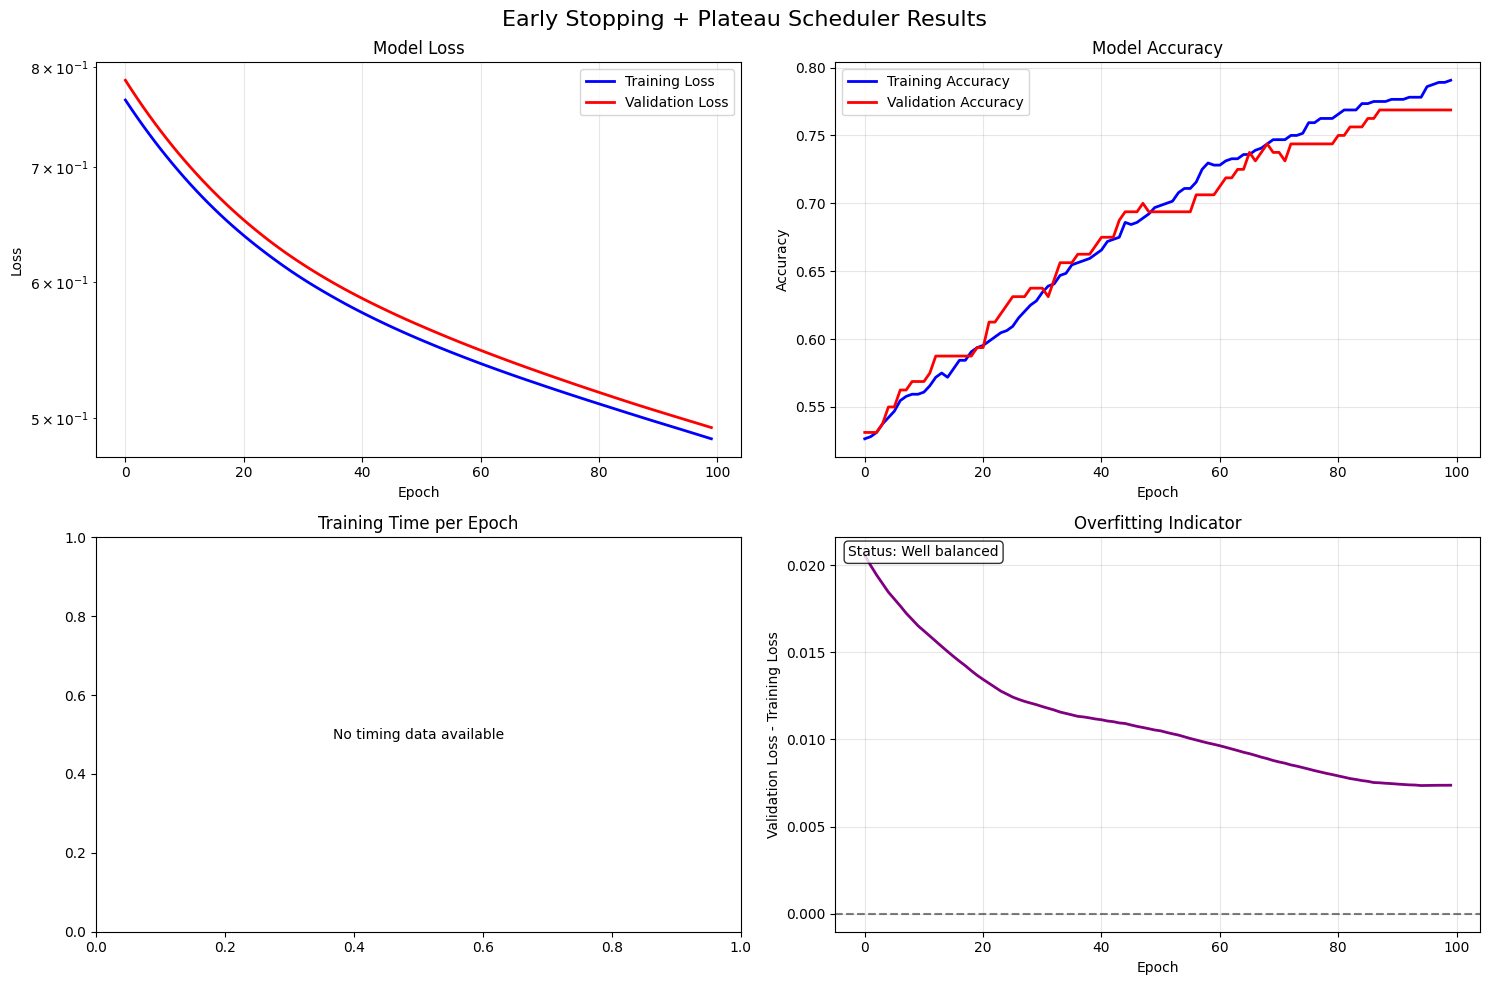


✓ Advanced training visualization completed!


In [9]:
# Visualization function for advanced training results
def plot_advanced_training_results(history: Dict[str, List[float]], title: str = "Training Results"):
    """
    Plot comprehensive training results
    
    Args:
        history: Training history dictionary
        title: Plot title
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Loss plot
    axes[0, 0].plot(history['loss'], 'b-', linewidth=2, label='Training Loss')
    if 'val_loss' in history:
        axes[0, 0].plot(history['val_loss'], 'r-', linewidth=2, label='Validation Loss')
    
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Model Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].set_yscale('log')
    
    # Accuracy plot
    axes[0, 1].plot(history['accuracy'], 'b-', linewidth=2, label='Training Accuracy')
    if 'val_accuracy' in history:
        axes[0, 1].plot(history['val_accuracy'], 'r-', linewidth=2, label='Validation Accuracy')
    
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].set_title('Model Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Training time per epoch
    if 'epoch_time' in history:
        axes[1, 0].plot(history['epoch_time'], 'g-', linewidth=2)
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Time (seconds)')
        axes[1, 0].set_title('Training Time per Epoch')
        axes[1, 0].grid(True, alpha=0.3)
    else:
        axes[1, 0].text(0.5, 0.5, 'No timing data available', 
                       ha='center', va='center', transform=axes[1, 0].transAxes)
        axes[1, 0].set_title('Training Time per Epoch')
    
    # Loss difference (overfitting indicator)
    if 'val_loss' in history:
        loss_diff = np.array(history['val_loss']) - np.array(history['loss'])
        axes[1, 1].plot(loss_diff, 'purple', linewidth=2)
        axes[1, 1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Validation Loss - Training Loss')
        axes[1, 1].set_title('Overfitting Indicator')
        axes[1, 1].grid(True, alpha=0.3)
        
        # Add interpretation text
        final_diff = loss_diff[-1]
        if final_diff > 0.1:
            status = "High overfitting"
        elif final_diff > 0.05:
            status = "Moderate overfitting"
        elif final_diff > -0.05:
            status = "Well balanced"
        else:
            status = "Possible underfitting"
        
        axes[1, 1].text(0.02, 0.98, f'Status: {status}', 
                        transform=axes[1, 1].transAxes, 
                        verticalalignment='top',
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    else:
        axes[1, 1].text(0.5, 0.5, 'No validation data available', 
                       ha='center', va='center', transform=axes[1, 1].transAxes)
        axes[1, 1].set_title('Overfitting Indicator')
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Plot results from Test 1
print("Advanced Training Results Visualization")
print("=" * 40)

plot_advanced_training_results(history1, "Early Stopping + Plateau Scheduler Results")

print("\n✓ Advanced training visualization completed!")


Learning Rate Scheduler Comparison


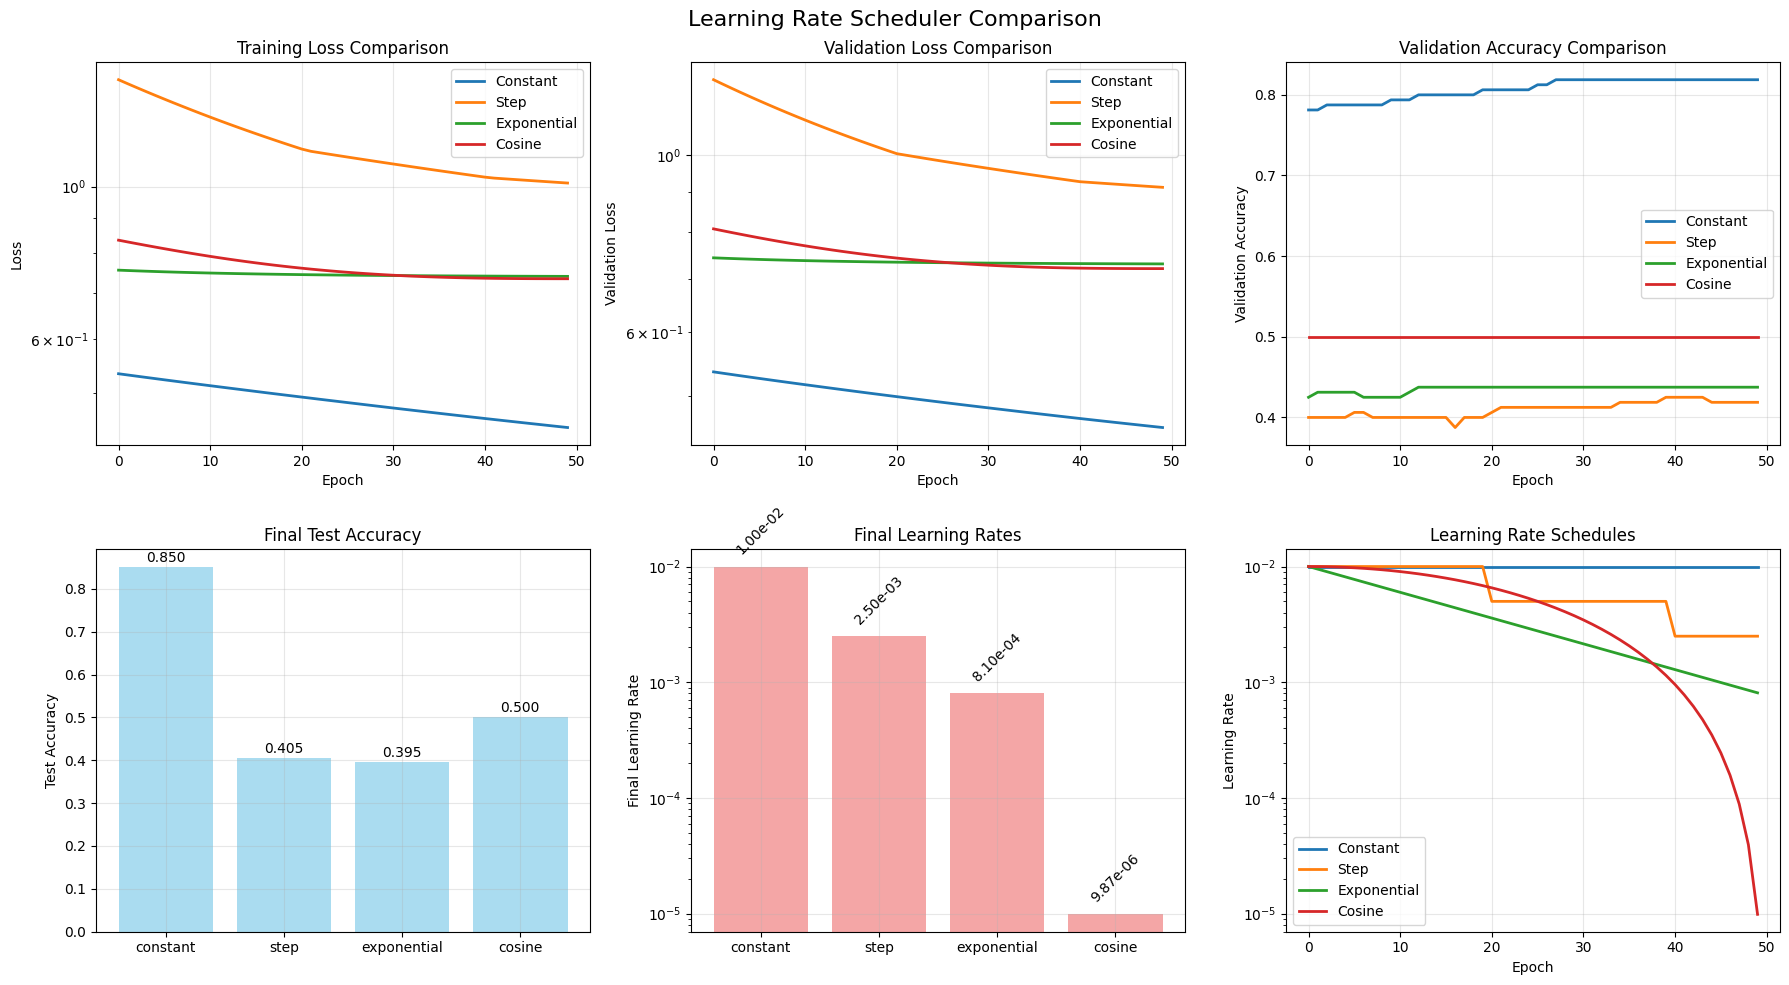


Scheduler Comparison Summary:
Scheduler    Test Acc   Test Loss    Final LR    
--------------------------------------------------
Constant     0.8500     0.388412     1.00e-02    
Step         0.4050     1.087889     2.50e-03    
Exponential  0.3950     0.750049     8.10e-04    
Cosine       0.5000     0.748838     9.87e-06    

Best performer: Constant (Test Accuracy: 0.8500)

✓ Scheduler comparison visualization completed!


In [10]:
# Scheduler comparison visualization
def plot_scheduler_comparison(scheduler_results: Dict[str, Dict]):
    """
    Plot comparison of different learning rate schedulers
    
    Args:
        scheduler_results: Results from different schedulers
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # Training loss comparison
    axes[0, 0].set_title('Training Loss Comparison')
    for scheduler_name, results in scheduler_results.items():
        axes[0, 0].plot(results['history']['loss'], linewidth=2, label=scheduler_name.title())
    
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].set_yscale('log')
    
    # Validation loss comparison
    axes[0, 1].set_title('Validation Loss Comparison')
    for scheduler_name, results in scheduler_results.items():
        axes[0, 1].plot(results['history']['val_loss'], linewidth=2, label=scheduler_name.title())
    
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Validation Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].set_yscale('log')
    
    # Validation accuracy comparison
    axes[0, 2].set_title('Validation Accuracy Comparison')
    for scheduler_name, results in scheduler_results.items():
        axes[0, 2].plot(results['history']['val_accuracy'], linewidth=2, label=scheduler_name.title())
    
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('Validation Accuracy')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
    
    # Final test accuracy comparison
    scheduler_names = list(scheduler_results.keys())
    test_accuracies = [scheduler_results[name]['test_accuracy'] for name in scheduler_names]
    test_losses = [scheduler_results[name]['test_loss'] for name in scheduler_names]
    final_lrs = [scheduler_results[name]['final_lr'] for name in scheduler_names]
    
    axes[1, 0].bar(scheduler_names, test_accuracies, alpha=0.7, color='skyblue')
    axes[1, 0].set_ylabel('Test Accuracy')
    axes[1, 0].set_title('Final Test Accuracy')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Add values on bars
    for i, acc in enumerate(test_accuracies):
        axes[1, 0].text(i, acc + 0.005, f'{acc:.3f}', ha='center', va='bottom')
    
    # Final learning rates
    axes[1, 1].bar(scheduler_names, final_lrs, alpha=0.7, color='lightcoral')
    axes[1, 1].set_ylabel('Final Learning Rate')
    axes[1, 1].set_title('Final Learning Rates')
    axes[1, 1].set_yscale('log')
    axes[1, 1].grid(True, alpha=0.3)
    
    # Add values on bars
    for i, lr in enumerate(final_lrs):
        axes[1, 1].text(i, lr * 1.2, f'{lr:.2e}', ha='center', va='bottom', rotation=45)
    
    # Learning rate evolution (show one example)
    # Create a mock learning rate schedule for visualization
    epochs = range(50)
    
    # Simulate learning rate schedules
    constant_lrs = [0.01] * 50
    step_lrs = [0.01 if e < 20 else 0.005 if e < 40 else 0.0025 for e in epochs]
    exp_lrs = [0.01 * (0.95 ** e) for e in epochs]
    cosine_lrs = [0 + (0.01 - 0) * (1 + np.cos(np.pi * e / 50)) / 2 for e in epochs]
    
    axes[1, 2].plot(epochs, constant_lrs, linewidth=2, label='Constant')
    axes[1, 2].plot(epochs, step_lrs, linewidth=2, label='Step')
    axes[1, 2].plot(epochs, exp_lrs, linewidth=2, label='Exponential')
    axes[1, 2].plot(epochs, cosine_lrs, linewidth=2, label='Cosine')
    
    axes[1, 2].set_xlabel('Epoch')
    axes[1, 2].set_ylabel('Learning Rate')
    axes[1, 2].set_title('Learning Rate Schedules')
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)
    axes[1, 2].set_yscale('log')
    
    plt.suptitle('Learning Rate Scheduler Comparison', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Print summary table
    print("\nScheduler Comparison Summary:")
    print("=" * 50)
    print(f"{'Scheduler':<12} {'Test Acc':<10} {'Test Loss':<12} {'Final LR':<12}")
    print("-" * 50)
    
    for name in scheduler_names:
        result = scheduler_results[name]
        print(f"{name.title():<12} {result['test_accuracy']:<10.4f} "
              f"{result['test_loss']:<12.6f} {result['final_lr']:<12.2e}")
    
    # Find best performer
    best_scheduler = max(scheduler_names, key=lambda x: scheduler_results[x]['test_accuracy'])
    print(f"\nBest performer: {best_scheduler.title()} "
          f"(Test Accuracy: {scheduler_results[best_scheduler]['test_accuracy']:.4f})")

# Plot scheduler comparison
print("\nLearning Rate Scheduler Comparison")
print("=" * 40)

plot_scheduler_comparison(scheduler_results)

print("\n✓ Scheduler comparison visualization completed!")

## Progress Tracking Checklist

Mark each completed section:

- [ ] ✅ **Environment Setup**: Imported libraries and established training loop principles
- [ ] ✅ **Learning Rate Schedulers**: Implemented various scheduling strategies (constant, step, exponential, plateau, cosine)
- [ ] ✅ **Early Stopping**: Built early stopping system to prevent overfitting
- [ ] ✅ **Model Checkpointing**: Created checkpoint system to save best models
- [ ] ✅ **Training Monitor**: Implemented comprehensive progress monitoring and logging
- [ ] ✅ **Advanced Trainer**: Built sophisticated training loop with all modern features
- [ ] ✅ **Neural Network Components**: Imported and adapted components from previous lab
- [ ] ✅ **Training Tests**: Successfully tested training loop with real datasets
- [ ] ✅ **Scheduler Comparison**: Compared different learning rate scheduling strategies
- [ ] ✅ **Visualization**: Created comprehensive training results and comparison visualizations

## Key Concepts Summary

**Modern Training Loop Components:**
1. **Learning Rate Scheduling**: Adaptive adjustment of learning rates during training
2. **Early Stopping**: Prevents overfitting by monitoring validation metrics
3. **Model Checkpointing**: Saves best models based on specified criteria
4. **Progress Monitoring**: Real-time tracking of training metrics and performance
5. **Batch Processing**: Efficient handling of different batch sizes and data loading

**Learning Rate Schedulers:**
- **Constant**: Maintains fixed learning rate throughout training
- **Step**: Reduces learning rate at fixed intervals
- **Exponential**: Smooth exponential decay of learning rate
- **Plateau**: Reduces learning rate when metric stops improving
- **Cosine**: Cosine annealing for smooth learning rate variation

**Training Best Practices:**
- Monitor both training and validation metrics
- Use early stopping to prevent overfitting
- Save model checkpoints regularly
- Implement learning rate scheduling for better convergence
- Track training time and computational efficiency
- Visualize training progress for debugging

**Production Considerations:**
- Robust error handling and recovery
- Comprehensive logging and monitoring
- Efficient memory and computational resource usage
- Reproducible training with proper seed management
- Scalable batch processing strategies

## Troubleshooting

**Common Issues and Solutions:**

1. **Training Instability**
   - *Problem*: Loss oscillates or explodes
   - *Solutions*: Reduce learning rate, implement gradient clipping, check data preprocessing

2. **Slow Convergence**
   - *Problem*: Training takes too long to converge
   - *Solutions*: Increase learning rate, use learning rate scheduling, improve initialization

3. **Overfitting**
   - *Problem*: Validation loss increases while training loss decreases
   - *Solutions*: Use early stopping, add regularization, increase validation monitoring

4. **Memory Issues**
   - *Problem*: Out of memory errors during training
   - *Solutions*: Reduce batch size, implement gradient accumulation, use data generators

5. **Learning Rate Scheduling Issues**
   - *Problem*: Learning rate reduces too quickly or slowly
   - *Solutions*: Adjust scheduler parameters, monitor learning rate changes, try different schedulers

6. **Early Stopping Too Aggressive**
   - *Problem*: Training stops before optimal convergence
   - *Solutions*: Increase patience, reduce min_delta, check validation data quality

## Validation Steps

**Verify Your Implementation:**
1. ✅ Training loss consistently decreases over epochs
2. ✅ Learning rate scheduling works as expected
3. ✅ Early stopping activates when validation metrics plateau
4. ✅ Model checkpoints save at appropriate times
5. ✅ Training monitor logs all metrics correctly
6. ✅ Batch processing handles different sizes properly

## Cleanup Instructions

**After Lab Completion:**
1. Save your notebook with all training results and visualizations
2. Clear large variables if memory is limited:
   ```python
   # Uncomment if needed
   # del history1, scheduler_results
   # del X_train_scaled, X_val_scaled, X_test_scaled
   # del model, trainer
   ```
3. Close plots: `plt.close('all')`

## Next Steps

Your advanced training loop implementation provides a solid foundation for:
- **Production ML Systems**: Robust, monitored training pipelines
- **Hyperparameter Optimization**: Integration with automated tuning systems
- **Distributed Training**: Extension to multi-GPU and multi-node training
- **Advanced Optimizers**: Integration with Adam, RMSprop, and other optimizers
- **Deep Learning Frameworks**: Understanding of how PyTorch/TensorFlow training works

The training loop patterns you've learned are used in all modern deep learning frameworks and are essential for successful machine learning projects.

**Congratulations! You've completed Lab 2.5 - Training Loop Implementation!** 🎉